In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import math
import itertools
import csv

from colorama import Fore

from statsmodels.tsa.arima.model import ARIMA

from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
import math

import warnings
from statsmodels.tools.sm_exceptions import ConvergenceWarning, ValueWarning

In [ ]:
# TO MODIFY
df = pd.read_csv("./datasets/Benchmarking on Microservices Configurations and the Impact on the Performance in Cloud Native Environments/amf-performance.csv")
df['datetime'] = pd.to_datetime(df['time'], unit='s') # resample function needs a datetime column
df = df.drop(['time', 'lat75', 'lat80', 'lat90', 'lat95', 'lat98', 'lat99', 'lat100'], axis=1)

# additional features
df['day'] = pd.DatetimeIndex(df['datetime']).day
df['hour'] = pd.DatetimeIndex(df['datetime']).hour

# Remove from ram_limit 'M' and convert the column to integer
df['ram_limit'] = df['ram_limit'].str.replace('M', '').astype(int)

# Convert ram usage from bytes to MB
df['ram_usage'] = df['ram_usage'] / (1024 ** 2)
df

,ram_limit,cpu_limit,ram_usage,cpu_usage,n,mean,lat50,datetime,day,hour
0,2048,2.0,72.214844,0.003700,10,194402,210678,2021-11-10 14:06:18,10,14
1,2048,2.0,133.757812,0.003700,20,301621,304027,2021-11-10 14:06:28,10,14
2,2048,2.0,175.703125,0.052663,30,465659,465392,2021-11-10 14:06:39,10,14
3,2048,2.0,207.597656,0.052663,40,592062,588150,2021-11-10 14:06:50,10,14
4,2048,2.0,291.449219,0.120889,50,862765,863232,2021-11-10 14:07:01,10,14
...,...,...,...,...,...,...,...,...,...,...
27408,3328,1.0,793.230469,0.470948,80,1311496,1374454,2021-11-27 08:19:17,27,8
27409,3328,1.0,401.250000,0.248292,90,1663628,1793633,2021-11-27 08:19:29,27,8
27410,3328,1.0,407.312500,0.579697,100,4243770,4414612,2021-11-27 08:19:44,27,8
27411,3328,1.0,412.261719,0.475063,110,2152941,2262854,2021-11-27 08:19:56,27,8


Remove the null values at the beginning

In [3]:
# Set the filter condition based on the desired date and time
df_copy = df.copy()
df_copy['datetime'] = pd.to_datetime(df['datetime'])
filter_condition = df_copy['datetime'] > '2021-11-12 14:00:00'

# Apply the filter to get the subset of the DataFrame
filtered_df = df_copy[filter_condition]

# Resample the data based on the frequency
frequency = '1h'
df_max = filtered_df.resample(frequency, on='datetime').max()

df_max

,ram_limit,cpu_limit,ram_usage,cpu_usage,n,mean,lat50,day,hour
datetime,,,,,,,,,
2021-11-12 15:00:00,4096.0,4.0,1147.921875,1.358302,520.0,67451009.0,67428077.0,12.0,15.0
2021-11-12 16:00:00,3584.0,4.0,1783.832031,1.385498,520.0,68222008.0,68162522.0,12.0,16.0
2021-11-12 17:00:00,3072.0,4.0,1762.128906,1.382358,550.0,77777013.0,77747786.0,12.0,17.0
2021-11-12 18:00:00,2304.0,4.0,1768.171875,1.358083,530.0,70557306.0,70546856.0,12.0,18.0
2021-11-12 19:00:00,1280.0,4.0,1684.777344,1.307712,520.0,68996878.0,68965997.0,12.0,19.0
...,...,...,...,...,...,...,...,...,...
2021-11-27 04:00:00,1280.0,2.0,1672.492188,1.323356,550.0,98065398.0,98048590.0,27.0,4.0
2021-11-27 05:00:00,4096.0,2.0,975.718750,1.257932,550.0,98199627.0,98221357.0,27.0,5.0
2021-11-27 06:00:00,3840.0,1.5,1751.023438,1.324840,550.0,96423698.0,96467143.0,27.0,6.0


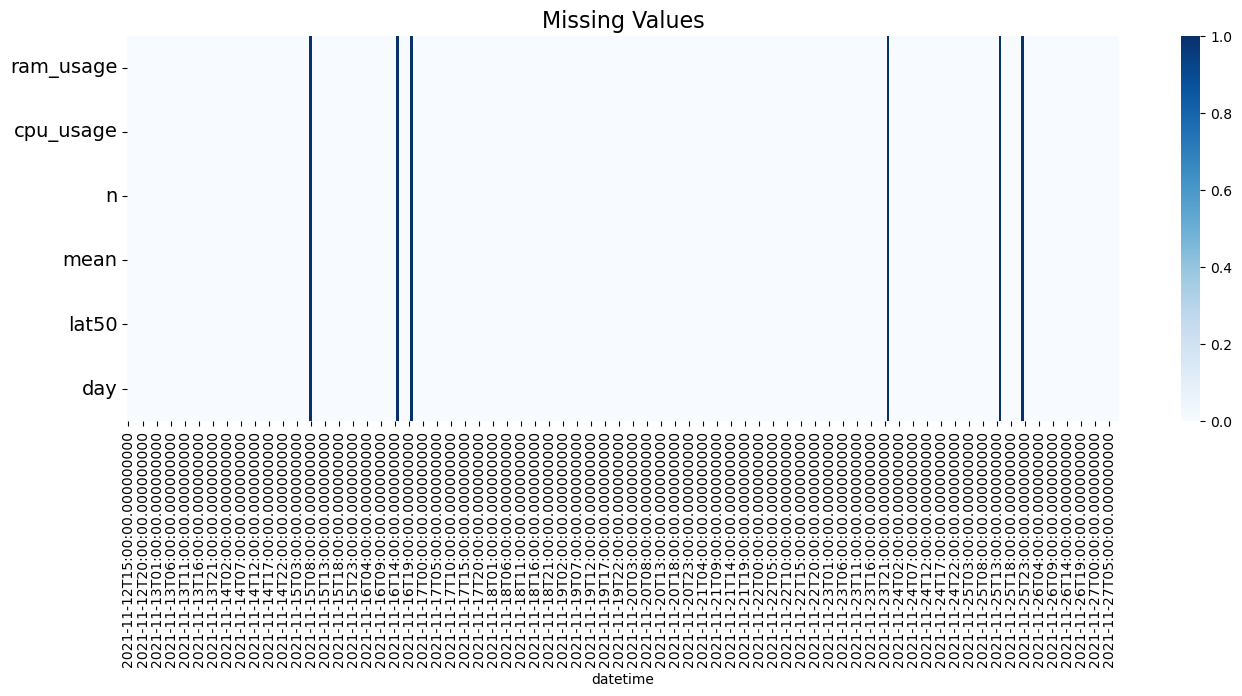

In [4]:
f, ax = plt.subplots(nrows=1, ncols=1, figsize=(16,5))

sns.heatmap(df_max.iloc[:,2:-1].T.isna(), cmap='Blues') #drop useless columns
ax.set_title('Missing Values', fontsize=16)

# Rotate y-axis labels
ax.set_yticklabels(ax.get_yticklabels(), rotation=0)  # Set the rotation angle as needed

for tick in ax.yaxis.get_major_ticks():
    tick.label1.set_fontsize(14)
plt.show()

In [5]:
print(f"Frequency: {frequency}\nN. null: {df_max.isna().sum()[0]} \n% null over total: {df_max.isna().sum()[0]/len(df_max)*100:.2f}%")

Frequency: 1h
N. null: 6 
% null over total: 1.69%


C:\Users\Alice Piemonti\AppData\Local\Temp\ipykernel_12236\61170822.py:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(f"Frequency: {frequency}\nN. null: {df_max.isna().sum()[0]} \n% null over total: {df_max.isna().sum()[0]/len(df_max)*100:.2f}%")


Interpolate to fill the null values in the df

In [6]:
interpolated_df = df_max.interpolate()
interpolated_df.isna().sum()

ram_limit    0
cpu_limit    0
ram_usage    0
cpu_usage    0
n            0
mean         0
lat50        0
day          0
hour         0
dtype: int64

# ARIMA

In [7]:
train_size = int(0.7 * len(interpolated_df))
test_size = len(interpolated_df) - train_size

univariate_memory_usage_df = interpolated_df.reset_index()[['datetime', 'ram_usage']].copy()
univariate_memory_usage_df.columns = ['ds', 'y']

train_memory_usage = univariate_memory_usage_df.iloc[:train_size, :]

x_train_memory_usage, y_train_memory_usage = pd.DataFrame(univariate_memory_usage_df.iloc[:train_size, 0]), pd.DataFrame(univariate_memory_usage_df.iloc[:train_size, 1])
x_valid_memory_usage, y_valid_memory_usage = pd.DataFrame(univariate_memory_usage_df.iloc[train_size:, 0]), pd.DataFrame(univariate_memory_usage_df.iloc[train_size:, 1])

print(len(x_train_memory_usage), len(x_valid_memory_usage))

247 107


Forecast only the validation part, retrain the model at each step

In [8]:
n_iterations = test_size 

# ignore convergence warnings
warnings.simplefilter('ignore', ConvergenceWarning)

# make a copy of training set
y_train_temp = y_train_memory_usage.copy()

In [9]:
# first prediction
# Fit model
model = ARIMA(y_train_temp, order=(2,0,2)) # (p,d,q) --> p = lag order, d = degree of differencing, q = order of moving average
model_fit = model.fit()

# predict 1 point
prediction = model_fit.forecast()
prediction = pd.DataFrame(prediction, columns=['y'])

# initialize prediction array
forecasted_memory_usage = prediction

# update training set
y_train_temp = pd.concat([y_train_temp, y_valid_memory_usage['y'][:1]], ignore_index=False)

In [10]:
for i in range(1, n_iterations):
    # Fit model
    model = ARIMA(y_train_temp, order=(2,0,2)) # (p,d,q) --> p = lag order, d = degree of differencing, q = order of moving average
    model_fit = model.fit()

    # predict 1 point
    prediction = model_fit.forecast()
    prediction = pd.DataFrame(prediction, columns=['y'])

    # update prediction array
    forecasted_memory_usage = pd.concat([forecasted_memory_usage, prediction])

    # update training set
    y_train_temp = pd.concat([y_train_temp, y_valid_memory_usage['y'].iloc[[i]]], ignore_index=False)

In [11]:
# reshape for consistency
y_valid_memory_usage_res = y_valid_memory_usage.to_numpy().ravel()
valid_len = len(y_valid_memory_usage_res)
#y_pred_cpu_usage_res = y_pred_cpu_usage[:valid_len]

# Calcuate metrics
score_mae_memory_usage = mean_absolute_error(y_valid_memory_usage_res, forecasted_memory_usage)
score_rmse_memory_usage = math.sqrt(mean_squared_error(y_valid_memory_usage_res, forecasted_memory_usage))
score_mape_memory_usage = mean_absolute_percentage_error(y_valid_memory_usage_res, forecasted_memory_usage)

print(Fore.GREEN + 'RMSE: {}'.format(score_rmse_memory_usage))
print('MAE: {}'.format(score_mae_memory_usage))
print('MAPE: {}'.format(score_mape_memory_usage))

RMSE: 400.278837425055
MAE: 366.2350974841684
MAPE: 0.32353644274138765


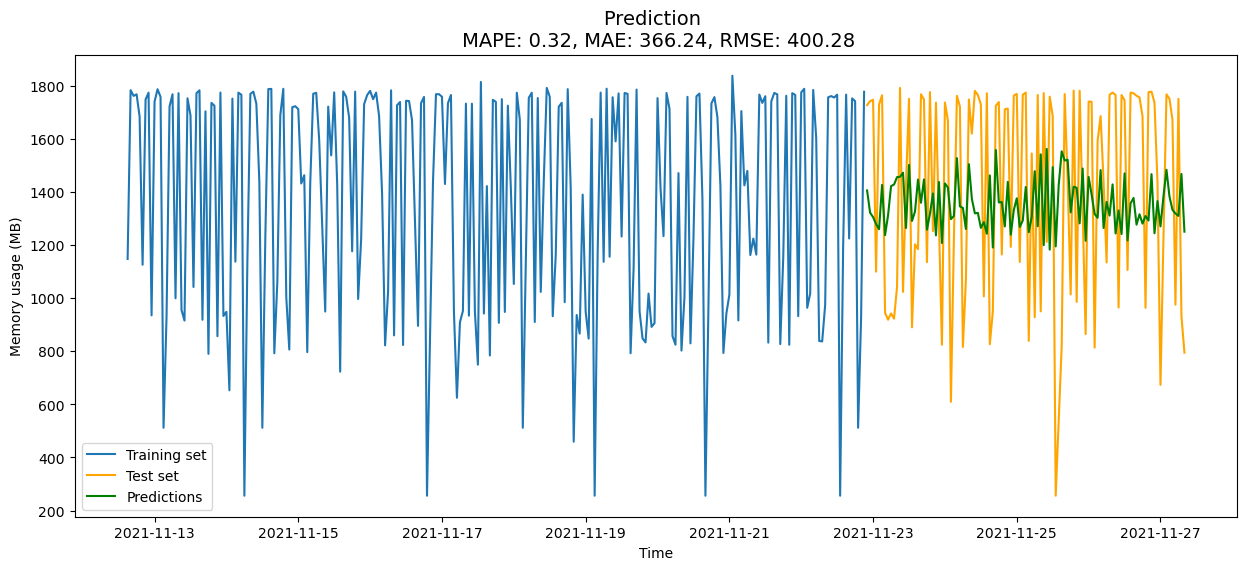

In [12]:
# Plot the forecast
f, ax = plt.subplots(1)
f.set_figheight(6)
f.set_figwidth(15)

plt.plot(y_train_memory_usage.set_index(x_train_memory_usage['ds']))
plt.plot(pd.DataFrame(y_valid_memory_usage_res).set_index(x_valid_memory_usage['ds']), color='orange')
plt.plot(pd.DataFrame(forecasted_memory_usage).set_index(x_valid_memory_usage['ds']), color='green')
plt.xticks(rotation=45)
plt.title(f'Prediction \n MAPE: {score_mape_memory_usage:.2f}, MAE: {score_mae_memory_usage:.2f}, RMSE: {score_rmse_memory_usage:.2f}', fontsize=14)
plt.xlabel('Time')
plt.ylabel('Memory usage (MB)')
plt.legend(['Training set', 'Test set', 'Predictions'])
plt.xticks(rotation=0)
plt.show()